# Object Detection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

## Template Matching

In [ ]:
img = cv2.imread('data/sammy.jpg')
img_crop = cv2.imread('data/sammy_face.jpg')

method_names = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR', 'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']

for method_name in method_names:
    method = eval(method_name)
    img_copy = img.copy()
    img_result = cv2.matchTemplate(img_copy, img_crop, method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(img_result)
    
    if method_name in method_names[-2:]:  # sqdiff methods is different from others
        top_left = min_loc  # (x, y)
    else:
        top_left = max_loc
        
    height, width, channels = img_crop.shape
    
    bottom_right = (top_left[0] + width, top_left[1] + height)
    
    cv2.rectangle(img_copy, top_left, bottom_right, (255, 0, 0), 10)
    
    plt.subplot(121)
    plt.imshow(img_result)
    plt.title('Heatmap')
    
    plt.subplot(122)
    plt.imshow(img_copy)
    plt.title('Detection')
    
    plt.suptitle(method_name)
    
    plt.show()

## Corner Detection
* Harris Corner Detection
    * Searches for large gradient changes in a kernel (at a corner, kernel faces large gradient changes using sorbel operator)
    * Uses scoring function: $\lambda_1\lambda_2 - k(\lambda_1+\lambda_2)$
* Shi-Tomasi
    * Same as Harris, just uses a different scoring function: $min(\lambda_1,\lambda_2)$

In [33]:
img_flat = cv2.imread('data/flat_chessboard.png')
img_real = cv2.imread('data/real_chessboard.jpg')

img_flat_gray = cv2.cvtColor(img_flat, cv2.COLOR_BGR2GRAY)
img_real_gray = cv2.cvtColor(img_real, cv2.COLOR_BGR2GRAY)

# Convert dtype from int to float32 for compatibility with harris
img_flat_gray_float = np.float32(img_flat_gray)
img_real_gray_float = np.float32(img_real_gray)

### Harris Corner Detection

In [ ]:
# Harris
img_flat_gray_cnr = cv2.cornerHarris(
    src=img_flat_gray_float, 
    blockSize=2,
    ksize=3,
    k=0.04
)
img_flat_gray_cnr = cv2.dilate(img_flat_gray_cnr, None, iterations=5)
img_flat[img_flat_gray_cnr > 0] = [0, 0, 255]
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img_flat, cv2.COLOR_BGR2RGB))

# Same for real chessboard img
img_real_gray_cnr = cv2.cornerHarris(
    src=img_real_gray_float, 
    blockSize=2,
    ksize=3,
    k=0.04
)
img_real_gray_cnr = cv2.dilate(img_real_gray_cnr, None)
img_real[img_real_gray_cnr > 0.01 * img_real_gray_cnr.max()] = [0, 0, 255]
plt.subplot(122)
plt.imshow(cv2.cvtColor(img_real, cv2.COLOR_BGR2RGB))
plt.show()

### Shi-Tomasi Corner Detection
Good Features to Track Paper

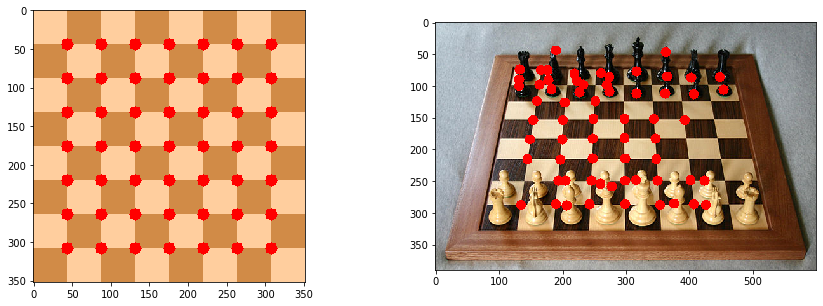

In [34]:
img_flat_cnr_st = cv2.goodFeaturesToTrack(
    image=img_flat_gray,
    maxCorners=0,
    qualityLevel=0.01,
    minDistance=10
)
img_real_cnr_st = cv2.goodFeaturesToTrack(
    image=img_real_gray,
    maxCorners=64,
    qualityLevel=0.01,
    minDistance=10
)

flat_cnrs = np.int0(img_flat_cnr_st)
real_cnrs = np.int0(img_real_cnr_st)

for flat_cnr in flat_cnrs:
    x, y = flat_cnr.ravel()
    cv2.circle(
        img=img_flat, 
        center=(x, y), 
        radius=8, 
        color=(0, 0, 255), 
        thickness=-1
    )
for real_cnr in real_cnrs:
    x, y = real_cnr.ravel()
    cv2.circle(
        img=img_real, 
        center=(x, y), 
        radius=8, 
        color=(0, 0, 255), 
        thickness=-1
    )

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img_flat, cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.imshow(cv2.cvtColor(img_real, cv2.COLOR_BGR2RGB))
plt.show()

## Edge Detection
* Canny
    * Steps:
        1. Apply Gaussian filter to smoothen image and remove noise (user should do custom one first)
        2. Find intensity gradients of image
        3. Apply non-max suppression to rid spurious (fake) edges
        4. Apply double threshold (user supplied, filter pix val < lb to 0 & pix val > ub to 255)
        5. Track edge by hysteresis: suppress other edges that are weak & not connected to strong edges


    * ROT for choosing lower & upper bounds of double threshold
        1. find median pix val of image
        2. calculate lower to be a fraction of median value (e.g. 0.7 * median)
        3. calculate upper to also be a fraction (e.g. 1.3 * median)
        4. use this as starting bounds and slowly adjust

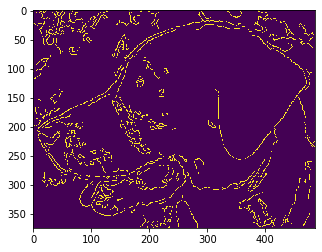

In [49]:
img = cv2.imread('data/sammy_face.jpg')

median_val = np.median(img)
lb = int(0.7 * median_val)
ub = int(1.3 * median_val)

img_blur = cv2.blur(src=img, ksize=(5, 5))
edges = cv2.Canny(image=img_blur, threshold1=lb, threshold2=ub+50)
plt.imshow(edges)

## Grid Detection
Image must be strictly grid/chessboard like pattern

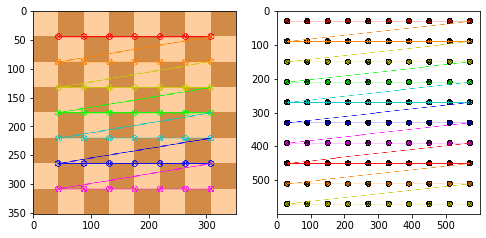

In [52]:
img = cv2.imread('data/flat_chessboard.png')
is_found, corners = cv2.findChessboardCorners(image=img, patternSize=(7, 7))

img_cnr1 = cv2.drawChessboardCorners(
    image=img, 
    patternSize=(7, 7), 
    corners=corners, 
    patternWasFound=is_found
)

img = cv2.imread('data/dot_grid.png')
is_found, corners = cv2.findCirclesGrid(
    image=img, 
    patternSize=(10, 10),
    flags=cv2.CALIB_CB_SYMMETRIC_GRID
)

img_cnr2 = cv2.drawChessboardCorners(
    image=img, 
    patternSize=(10, 10), 
    corners=corners, 
    patternWasFound=is_found
)

plt.figure(figsize=(8, 5))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img_cnr1, cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.imshow(cv2.cvtColor(img_cnr2, cv2.COLOR_BGR2RGB))
plt.show()

## Contour Detection
Able to find shapes, even internal or external shapes

In [54]:
img = cv2.imread('data/internal_external.png', 0)

img_contour, contours, hierarchy = cv2.findContours(
    image=img, 
    mode=cv2.RETR_CCOMP, 
    method=cv2.CHAIN_APPROX_SIMPLE
)

#### findContours
* returns image, contours, hierarchy
    * image - same as src img
    * contours - list of (set of points), with each set forming a line along each detected contours
        * e.g. 
        [#countourline1[
        #contourpt1[],
        #contourpt2[],...
        ],#contourline2[[],[]...],
        ...]
    * hierarchy - depends on mode, in retr_ccomp, both external & internal contours are detected, each type of contour is kept in a separate hierarchy
        * e.g. list of (set of 4 num), first 3 indicating the contour associated, last num indicating external or internal
        * [0[#countourline1[a, b, c, ind],...]]

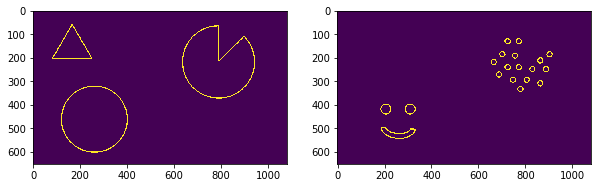

In [69]:
# form blank canvases
external_contours = np.zeros(img.shape)
internal_contours = np.zeros(img.shape)

# loop through & draw contours
for i in range(len(contours)):
    
    # if external contour
    if hierarchy[0][i][3] == -1:
        cv2.drawContours(
            image=external_contours, 
            contours=contours, 
            contourIdx=i, 
            color=(255, 0, 0), 
            thickness=3
        )
    
    # elif group 4 (this is arbitrary numbering by findContours)
    elif hierarchy[0][i][3] == 4:
        cv2.drawContours(
            image=internal_contours, 
            contours=contours, 
            contourIdx=i, 
            color=(255, 0, 0), 
            thickness=3
        )
    
    # elif group 0 (this is arbitrary numbering by findContours)
    elif hierarchy[0][i][3] == 0:
        cv2.drawContours(
            image=internal_contours, 
            contours=contours, 
            contourIdx=i, 
            color=(255, 0, 0), 
            thickness=3
        )
        
# plot
plt.figure(figsize=(10, 8))
plt.subplot(121)
plt.imshow(external_contours)
plt.subplot(122)
plt.imshow(internal_contours)
plt.show()

## Feature Matching
3 Methods
1. Brute-Force matching with ORB descriptors
2. Brute-Force matching with SIFT (Scale Invariant Feature Transform) descriptors & Ratio test
3. FLANN based matcher

In [102]:
img = cv2.imread('data/reeses_puffs.png', 0)
img2 = cv2.imread('data/many_cereals.jpg', 0)

### Brute Force ORB

In [ ]:
# brute force ORB
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(image=img, mask=None)
kp2, des2 = orb.detectAndCompute(image=img2, mask=None)

bf_orb = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches_orb = bf_orb.match(des1, des2)

# sort matches, and fetch lowest distance one
matches_orb = sorted(matches_orb, key=lambda x: x.distance)

reeses_matches = cv2.drawMatches(
    img1=img, 
    keypoints1=kp1, 
    img2=img2, 
    keypoints2=kp2, 
    matches1to2=matches_orb[:25], 
    outImg=None, 
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

plt.figure(figsize=(15, 10))
plt.subplot(111)
plt.imshow(reeses_matches, cmap='gray')
plt.show()

### Brute Force SIFT

In [ ]:
# Create SIFT Object
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# BFMatcher with default params
bf_sift = cv2.BFMatcher()
matches = bf_sift.knnMatch(des1,des2, k=2)

# Apply ratio test
good = []
for match1,match2 in matches:
    if match1.distance < 0.75*match2.distance:
        good.append([match1])

# cv2.drawMatchesKnn expects list of lists as matches.
matches_sift = cv2.drawMatchesKnn(img,kp1,img2,kp2,good,None,flags=2)

plt.figure(figsize=(15, 10))
plt.subplot(111)
plt.imshow(matches_sift, cmap='gray')
plt.show()

### FLANN Matcher

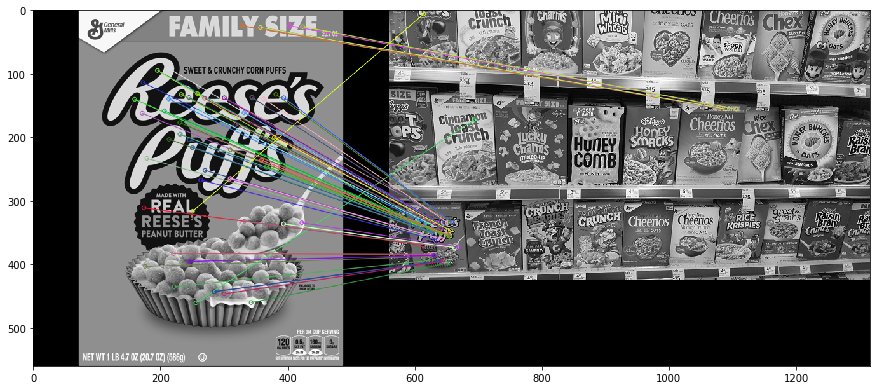

In [108]:
# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)  

flann = cv2.FlannBasedMatcher(index_params,search_params)

matches = flann.knnMatch(des1,des2,k=2)

good = []

# ratio test
for i,(match1,match2) in enumerate(matches):
    if match1.distance < 0.7*match2.distance:
        good.append([match1])

matches_flann = cv2.drawMatchesKnn(img,kp1,img2,kp2,good,None,flags=2)

plt.figure(figsize=(15, 10))
plt.subplot(111)
plt.imshow(matches_flann, cmap='gray')
plt.show()

## Watershed Algorithm
For finding contours

### With normal contour method

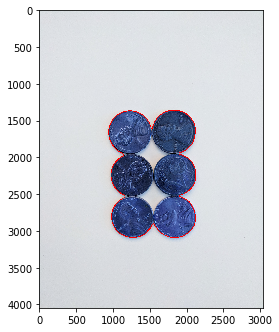

In [111]:
img = cv2.imread('data/pennies.jpg')

# Median Blur
img_blur = cv2.medianBlur(src=img, ksize=25)
# Grayscale
img_gray = cv2.cvtColor(img_blur, cv2.COLOR_BGR2GRAY)
# Bin Threshold
ret, img_th = cv2.threshold(img_gray, 160, 255, cv2.THRESH_BINARY_INV)
# Find contours
img_th_cntr, contours, hierarchy = cv2.findContours(img_th.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

for i in range(len(contours)):
    if hierarchy[0][i][3] == -1:
        cv2.drawContours(img, contours, i, (255, 0, 0), 10)

plt.figure(figsize=(4, 8))
plt.subplot(111)
plt.imshow(img, cmap='gray')
plt.show()

### With Watershed Algorithm
* When thresholding, can use Otsu's method which works well with watershed
* After first noise removal, can do distance transform
    * Distance transform further brightens central parts of an object further away from the edges/background

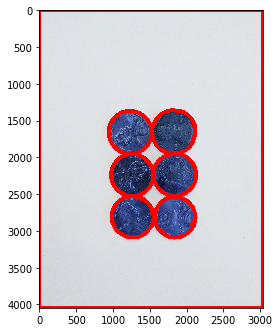

In [121]:
img = cv2.imread('data/pennies.jpg')

# Median Blur
img_blur = cv2.medianBlur(src=img, ksize=35)
# Grayscale
img_gray = cv2.cvtColor(img_blur, cv2.COLOR_BGR2GRAY)
# Threshold
ret, img_th = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
# Noise removal - white noise
img_open = cv2.morphologyEx(img_th, cv2.MORPH_OPEN, np.ones((3, 3), dtype=np.uint8), iterations=2)
# Distance transform - bright only in the middle of the coins
img_dt = cv2.distanceTransform(img_open, cv2.DIST_L2, 5)
# Another Thresholding to highlight the centre points of coins
ret, img_cpoints = cv2.threshold(img_dt, 0.7*img_dt.max(), 255, cv2.THRESH_BINARY)

# Prepare for watershed
img_cpoints = np.uint8(img_cpoints)
img_open_dilate = cv2.dilate(img_open, np.ones((3, 3), dtype=np.uint8), iterations=2)
img_subtract = cv2.subtract(img_open_dilate, img_cpoints)
ret, img_seeds = cv2.connectedComponents(img_cpoints)
img_seeds = img_seeds + 1
img_seeds[img_subtract == 255] = 0
img_seeds = cv2.watershed(img, img_seeds)

# Now coins are separated by diff shades of gray, recontour image
_, contours, hierarchy = cv2.findContours(img_seeds.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

for i in range(len(contours)):
    if hierarchy[0][i][3] == -1:
        cv2.drawContours(img, contours, i, (255, 0, 0), 50)

plt.figure(figsize=(4, 8))
plt.subplot(111)
plt.imshow(img, cmap='gray')
plt.show()